In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import sklearn.feature_selection as sfs
from collections import defaultdict
from SafeTransformer import SafeTransformer

from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, balanced_accuracy_score
from tqdm import tqdm_notebook as tqdm

In [3]:
seed = 20

# Load train dataset
### Load train features

In [4]:
df = pd.read_csv('../data/artificial_train.data', sep=' ', header=None).drop(500, axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,485,477,537,479,452,471,491,476,475,473,...,477,481,477,485,511,485,481,479,475,496
1,483,458,460,487,587,475,526,479,485,469,...,463,478,487,338,513,486,483,492,510,517
2,487,542,499,468,448,471,442,478,480,477,...,487,481,492,650,506,501,480,489,499,498
3,480,491,510,485,495,472,417,474,502,476,...,491,480,474,572,454,469,475,482,494,461
4,484,502,528,489,466,481,402,478,487,468,...,488,479,452,435,486,508,481,504,495,511


In [5]:
assert all(df.dtypes == np.int64)

### Load train labels

In [6]:
labels = pd.read_csv('../data/artificial_train.labels', header=None)[0]
labels.head()

0   -1
1   -1
2   -1
3    1
4    1
Name: 0, dtype: int64

In [11]:
labels.dtypes

dtype('int64')

In [12]:
labels.isna().sum()

0

In [13]:
labels.value_counts()

 1    1000
-1    1000
Name: 0, dtype: int64

# Features inspection
### Look for no variance features

In [10]:
df.var().describe()

count      500.000000
mean       911.887611
std       1629.050182
min          0.351060
25%        133.739788
50%        541.752937
75%       1261.657527
max      18104.930721
dtype: float64

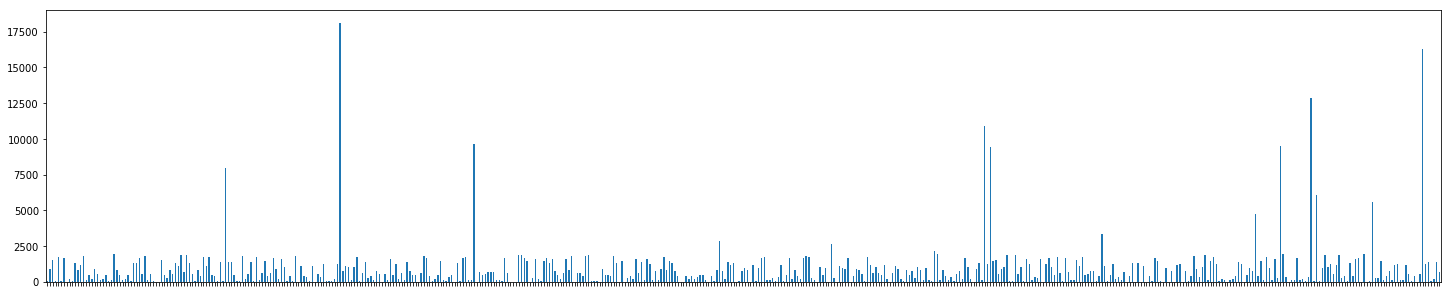

In [11]:
fig = plt.figure(figsize=(25,5))
df.var().plot(kind='bar')
plt.xticks(range(len(df.columns)), [])
None

### Correlation

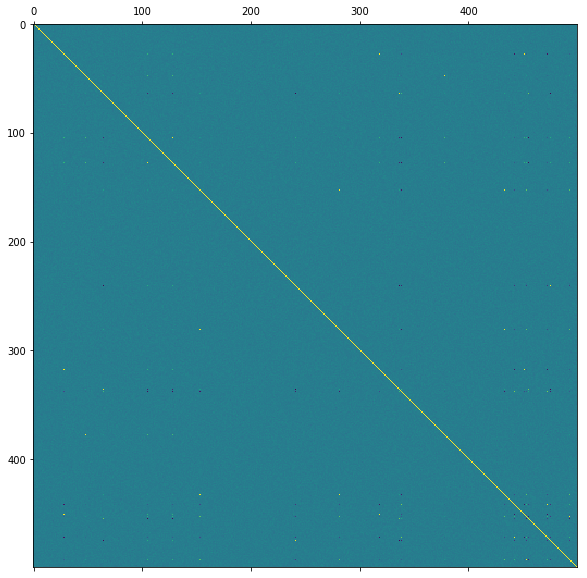

In [12]:
corr = df.corr().values
fig = plt.figure(figsize=(10,10))
plt.matshow(corr, 0)
None

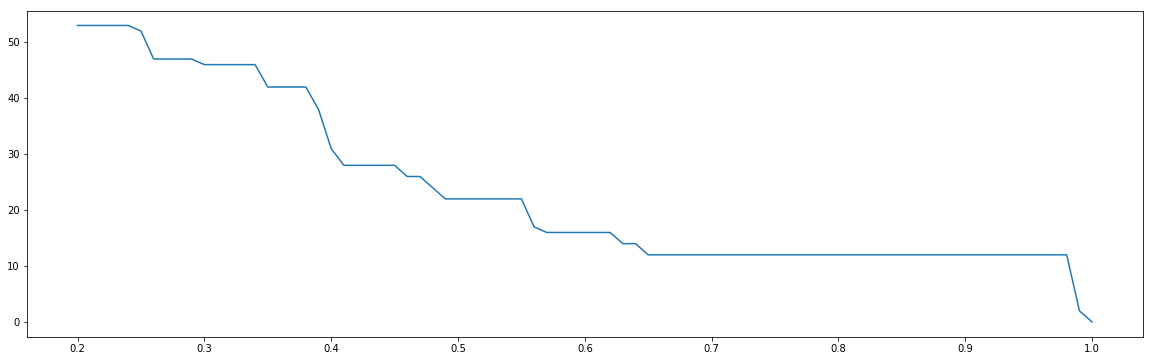

In [13]:
thresholds = np.linspace(0.2, 1, 81)
correlated_num = []
for threshold in thresholds: 
    corr_pairs = np.nonzero(corr >= threshold)
    correlated_num.append((len(corr_pairs[0])-500) / 2)
    
fig = plt.figure(figsize=(20, 6))
plt.plot(thresholds, correlated_num)

### Drop highly correlated

In [14]:
class PairSetBucket:
    def __init__(self):
        self.id_to_bucket = {}
        
    def add_pair(self, a, b):
        if a in self.id_to_bucket and b in self.id_to_bucket:
            if self.id_to_bucket[a] is self.id_to_bucket[b]:
                return
            a_set = self.id_to_bucket[a]
            b_set = self.id_to_bucket[b]
            new_set = a_set.union(b_set)
            for x in new_set:
                self.id_to_bucket[x] = new_set
                
        elif a in self.id_to_bucket:
            a_set = self.id_to_bucket[a]
            self.id_to_bucket[b] = a_set
            a_set.add(b)
            
        elif b in self.id_to_bucket:
            b_set = self.id_to_bucket[b]
            self.id_to_bucket[a] = b_set
            b_set.add(a)
            
        else:
            new_set = set([a, b])
            self.id_to_bucket[a] = new_set
            self.id_to_bucket[b] = new_set
            
    def get(self, x):
        return self.id_to_bucket[x]
    
    def ngroups(self):
        return len(set([id(v) for v in self.id_to_bucket.values()]))
    
    def unique(self):
        done = []
        buckets = []
        for bucket in self.id_to_bucket.values():
            if not id(bucket) in done:
                done.append(id(bucket))
                buckets.append(bucket)
        return buckets

In [15]:
psb = PairSetBucket()
correlation_threshold = 0.9
corr_pairs = np.nonzero(corr >= correlation_threshold)
for a, b in zip(*corr_pairs):
    if a == b: continue
    psb.add_pair(a, b)

In [16]:
psb.unique()

[{28, 318, 451},
 {48, 378},
 {64, 336},
 {105, 128},
 {153, 281, 433},
 {241, 475},
 {442, 472},
 {453, 493}]

In [17]:
corr_del = []
for bucket in psb.unique():
    l_bucket = list(bucket)
    corr_del += l_bucket[1:]
    
print(corr_del)
df = df.drop(columns=corr_del)

[28, 318, 378, 336, 105, 433, 281, 475, 442, 453]


### Mutual information

In [18]:
max(sfs.mutual_info_classif(df, labels))

0.05204435813219832

## XGBoost
### Try to fit best model

In [ ]:
model = XGBClassifier()
params = {
    'max_depth': [2, 3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 300],
    'reg_lambda': [0.5, 1, 3, 9],
    'booster': ['gbtree', 'gblinear', 'dart'],
    'seed': [seed],
}
search = GridSearchCV(model, params, cv=3, n_jobs=-1)
search.fit(df, labels)
search.cv_results_

In [202]:
search.best_params_, search.best_score_

({'booster': 'gbtree',
  'learning_rate': 0.01,
  'max_depth': 5,
  'n_estimators': 100,
  'reg_lambda': 1,
  'seed': 20},
 0.802)

### Recursive feature search

Optimal number of features : 7


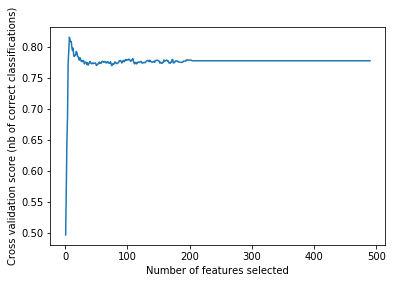

In [19]:
# model = search.best_estimator_
model = XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=1, seed=seed, n_jobs=-1)
rfecv = sfs.RFECV(estimator=model, step=1, cv=StratifiedKFold(2, random_state=seed),
              scoring='accuracy', n_jobs=-1)
rfecv.fit(df, labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

#### Columns chosen by rfecv

In [23]:
df.columns[rfecv.support_]

Int64Index([48, 128, 153, 241, 451, 472, 493], dtype='int64')

### Search all combinations of chosen columns

In [43]:
rfecv_columns = [48, 128, 153, 241, 451, 472, 493]
all_combinations = []
for i in range(1, 7):
    all_combinations += list(itertools.combinations(rfecv_columns, i))

    
model = XGBClassifier()
best_score, best_params, best_comb = 0, None, None
for comb in all_combinations:
    params = {
    'max_depth': [2, 3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 300],
    'reg_lambda': [0.5, 1, 3, 9],
    'n_jobs': [-1],
    'seed': [seed],
    }
    search = GridSearchCV(model, params, cv=5, n_jobs=-1)
    new_df = df[list(comb)]
    search.fit(new_df, labels)
    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_params = search.best_params_
        best_comb = comb

print(best_score)
print(best_params)
print(best_comb)

0.8615
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'n_jobs': -1, 'reg_lambda': 0.5, 'seed': 20}
(48, 128, 153, 241, 451, 493)


## Random Forest
### Try to fit

In [90]:
model = RandomForestClassifier()
params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 50, 100],
    'n_estimators': [20, 100, 300, 1000],
    'n_jobs': [-1],
    'random_state': [seed],
}
search = GridSearchCV(model, params, cv=3, n_jobs=-1)
search.fit(df, labels)
search.best_params_, search.best_score_

({'criterion': 'entropy',
  'min_samples_split': 10,
  'n_estimators': 1000,
  'n_jobs': -1,
  'random_state': 20},
 0.6405)

In [ ]:
len(df.columns)

Optimal number of features : 9


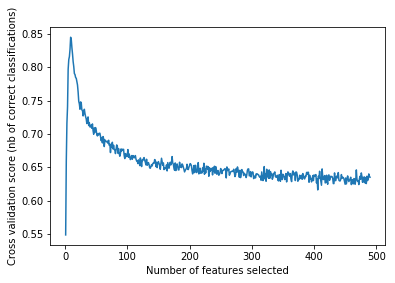

In [92]:
# model = search.best_estimator_
model = RandomForestClassifier(criterion='entropy', n_estimators=1000, min_samples_split=10, random_state=seed, n_jobs=-1)
rfecv = sfs.RFECV(estimator=model, step=1, cv=StratifiedKFold(2, random_state=seed),
              scoring='accuracy', n_jobs=-1)
rfecv.fit(df, labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [94]:
df.columns[rfecv.support_]

Int64Index([48, 64, 128, 153, 241, 338, 451, 472, 493], dtype='int64')

In [102]:
rfecv_columns = [48, 64, 128, 153, 241, 338, 451, 472, 493]
all_combinations = []
for i in range(1, len(rfecv_columns)):
    all_combinations += list(itertools.combinations(rfecv_columns, i))

    
model = RandomForestClassifier()
best_score, best_params, best_comb = 0, None, None
for comb in all_combinations:
    params = {
        'criterion': ['gini', 'entropy'],
        'min_samples_split': [2, 10, 50, 100],
        'n_estimators': [20, 100, 300, 1000],
        'n_jobs': [-1],
        'random_state': [seed],
    }
    search = GridSearchCV(model, params, cv=5, n_jobs=-1)
    new_df = df[list(comb)]
    search.fit(new_df, labels)
    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_params = search.best_params_
        best_comb = comb

print(best_score)
print(best_params)
print(best_comb)

0.887
{'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 20}
(48, 64, 128, 153, 241, 451, 472, 493)


0.881
{'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 20}
(48, 64, 153, 241, 451, 493)

### LightGBM

In [98]:
model = LGBMClassifier()
params = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [20, 100, 300, 1000],
    'reg_lambda': [0.5, 1, 3, 9],
    'num_leaves': [15, 31, 100],
    'n_jobs': [-1],
    'random_state': [seed],
}
search = GridSearchCV(model, params, cv=3, n_jobs=-1)
search.fit(df, labels)
search.best_params_, search.best_score_

({'learning_rate': 0.01,
  'n_estimators': 100,
  'n_jobs': -1,
  'num_leaves': 31,
  'random_state': 20,
  'reg_lambda': 0.5},
 0.796)

Optimal number of features : 10


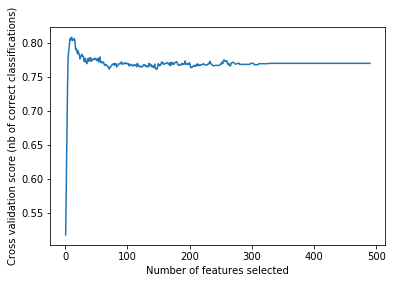

In [99]:
model = LGBMClassifier(learning_rate=0.01, n_estimators=100, num_leaves=31, reg_lambda=0.5, random_state=20, n_jobs=-1)
rfecv = sfs.RFECV(estimator=model, step=1, cv=StratifiedKFold(2, random_state=seed),
              scoring='accuracy', n_jobs=-1)
rfecv.fit(df, labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [100]:
df.columns[rfecv.support_]

Int64Index([48, 64, 128, 153, 241, 338, 451, 455, 472, 493], dtype='int64')

In [104]:
rfecv_columns = [48, 64, 128, 153, 241, 338, 451, 455, 472, 493]
all_combinations = []
for i in range(1, len(rfecv_columns)):
    all_combinations += list(itertools.combinations(rfecv_columns, i))

    
model = LGBMClassifier()
best_score, best_params, best_comb = 0, None, None
for comb in all_combinations:
    params = {
        'learning_rate': [0.1, 0.01],
        'n_estimators': [20, 100, 300, 1000],
        'reg_lambda': [0.5, 1, 3, 9],
        'num_leaves': [15, 31, 100],
        'n_jobs': [-1],
        'random_state': [seed],
    }
    search = GridSearchCV(model, params, cv=5, n_jobs=-1)
    new_df = df[list(comb)]
    search.fit(new_df, labels)
    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_params = search.best_params_
        best_comb = comb

print(best_score)
print(best_params)
print(best_comb)

0.8865
{'learning_rate': 0.1, 'n_estimators': 1000, 'n_jobs': -1, 'num_leaves': 100, 'random_state': 20, 'reg_lambda': 0.5}
(48, 64, 128, 153, 241, 451, 472, 493)


## Podsumowanie
### LGBM:
ważne - [48, 64, 128, 153, 241, 338, 451, 455, 472, 493]  
wybrane - [48, 64, 128, 153, 241, 451, 472, 493]  
parametry - {'learning_rate': 0.1, 'n_estimators': 1000, 'n_jobs': -1, 'num_leaves': 100, 'random_state': 20, 'reg_lambda': 0.5}  
score: 0.8865  

### RandomForest:
ważne - [48, 64, 128, 153, 241, 338, 451, 472, 493]  
wybrane - [48, 64, 128, 153, 241, 451, 472, 493]  
parametry - {'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 20}  
score:  0.887  

BONUS:  
[48, 64, 153, 241, 451, 493]  
{'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 20}  
0.881  

### XGBoost:
ważne - [48, 128, 153, 241, 451, 472, 493]  
wybrane - [48, 128, 153, 241, 451, 493]  
parametry - {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'n_jobs': -1, 'reg_lambda': 0.5, 'seed': 20}  
score: 0.8615  


In [38]:
new_df = df[[48, 64, 128, 153, 241, 451, 472, 493]]


# Lasso 

In [27]:
from sklearn.preprocessing import StandardScaler

model = LogisticRegression()
scaler = StandardScaler()
t_df = scaler.fit_transform(df)
params = {
    'penalty': ['l1'],
    'C': [0.005, 0.01, 0.05, 0.1, 1, 5],
    'solver': ['liblinear', 'saga'],
    'random_state': [20],
}
search = GridSearchCV(model, params, cv=3, n_jobs=-1)
search.fit(t_df, labels)
search.best_params_, search.best_score_

/home/bartek/Workspace/venvs/myenv/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/bartek/Workspace/venvs/myenv/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


({'C': 0.01, 'penalty': 'l1', 'random_state': 20, 'solver': 'saga'}, 0.6165)

In [28]:
model = LogisticRegression(**{'C': 0.05, 'penalty': 'l1', 'random_state': 20, 'solver': 'liblinear'})
model.fit(t_df, labels)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=20, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [29]:
lasso_most_important = np.argsort(np.abs(model.coef_))[0][::-1]
lasso_most_important[:20]

array([475,  48, 323, 424, 296, 204, 496, 431, 211, 481, 282,  10, 430,
        53, 205, 248, 384, 377, 425, 226])

In [30]:
lasso_features = np.argwhere(np.abs(model.coef_) > 0)[:, 1]
lasso_features

array([  1,   4,   5,  10,  12,  14,  18,  19,  23,  24,  26,  31,  38,
        41,  42,  43,  44,  46,  48,  49,  53,  55,  56,  60,  61,  63,
        65,  73,  85,  88, 103, 109, 114, 116, 119, 120, 121, 125, 127,
       130, 136, 137, 138, 139, 140, 146, 149, 152, 153, 154, 158, 159,
       161, 163, 164, 165, 167, 168, 175, 177, 184, 185, 193, 196, 197,
       199, 204, 205, 207, 211, 213, 214, 216, 217, 221, 223, 224, 226,
       227, 236, 237, 238, 241, 243, 245, 246, 248, 251, 253, 255, 264,
       267, 277, 278, 282, 285, 286, 296, 298, 299, 301, 303, 304, 306,
       307, 308, 309, 310, 313, 317, 321, 323, 329, 330, 333, 334, 340,
       343, 347, 348, 349, 352, 359, 370, 374, 377, 381, 382, 383, 384,
       395, 403, 409, 410, 411, 412, 413, 414, 415, 417, 419, 420, 421,
       422, 423, 424, 425, 430, 431, 432, 434, 441, 444, 445, 447, 449,
       454, 456, 457, 458, 461, 462, 466, 468, 471, 475, 478, 480, 481,
       490, 494, 496, 497])

In [32]:
model = RandomForestClassifier()
params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 30, 50, 100],
    'n_estimators': [20, 100, 300, 1000],
    'n_jobs': [-1],
    'random_state': [seed],
}
search = GridSearchCV(model, params, cv=5, scoring=make_scorer(balanced_accuracy_score), n_jobs=-1)
search.fit(df[lasso_most_important[:10]], labels)
search.best_params_, search.best_score_

({'criterion': 'gini',
  'min_samples_split': 100,
  'n_estimators': 300,
  'n_jobs': -1,
  'random_state': 20},
 0.6345)

### Try to connect lasso features with RCEV

In [51]:
lmi = lasso_most_important[:20]
rmi = [48, 64, 128, 153, 241, 451, 472, 493]
start_features = list(set(lmi).union(set(rmi)))
len(start_features)

27

In [53]:
new_df = df[start_features]
new_df.head()

,384,64,128,323,451,10,204,205,211,472,...,425,493,430,431,48,496,241,53,248,377
0,480,648,452,476,463,455,484,476,504,515,...,485,485,505,528,440,481,434,483,492,496
1,488,488,473,463,474,434,495,477,455,465,...,507,338,486,500,499,483,551,485,473,488
2,498,485,487,486,481,468,472,478,572,485,...,497,650,497,517,460,480,474,486,482,486
3,485,415,493,458,472,455,464,477,503,457,...,511,572,486,494,529,475,569,482,479,493
4,502,387,475,485,472,432,508,478,582,500,...,506,435,450,517,429,481,538,480,478,467


In [54]:
model = RandomForestClassifier()
params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 50, 100],
    'n_estimators': [20, 100, 300, 1000],
    'n_jobs': [-1],
    'random_state': [seed],
}
search = GridSearchCV(model, params, cv=3, n_jobs=-1)
search.fit(new_df, labels)
search.best_params_, search.best_score_

({'criterion': 'gini',
  'min_samples_split': 2,
  'n_estimators': 1000,
  'n_jobs': -1,
  'random_state': 20},
 0.81)

Optimal number of features : 8


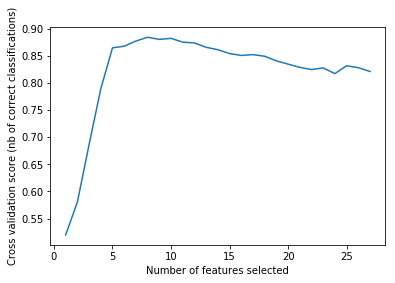

In [55]:
# model = search.best_estimator_
model = RandomForestClassifier(criterion='gini', n_estimators=1000, min_samples_split=2, random_state=seed, n_jobs=-1)
rfecv = sfs.RFECV(estimator=model, step=1, cv=StratifiedKFold(5, random_state=seed),
              scoring='accuracy', n_jobs=-1)
rfecv.fit(new_df, labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [57]:
new_df.columns[rfecv.support_]
# [{28, 318, 451},
#  {48, 378},
#  {64, 336},
#  {105, 128},
#  {153, 281, 433},
#  {241, 475},
#  {442, 472},
#  {453, 493}]
#  [48, 64, 128, 153, 241, 451, 472, 493]

Int64Index([64, 128, 451, 472, 153, 475, 493, 48], dtype='int64')

In [59]:
rfecv_columns = [64, 128, 451, 472, 153, 475, 493, 48]
all_scores = defaultdict(list)

model = RandomForestClassifier()
best_score, best_params, best_comb = 0, None, None

for i in tqdm(range(4, len(rfecv_columns))):
    for comb in itertools.combinations(rfecv_columns, i):
        params = {
            'criterion': ['gini', 'entropy'],
            'min_samples_split': [2, 10, 50, 100],
            'n_estimators': [20, 100, 300, 1000],
            'n_jobs': [-1],
            'random_state': [seed],
        }
        search = GridSearchCV(model, params, cv=5, n_jobs=-1)
        t_df = df[list(comb)]
        search.fit(t_df, labels)
        if search.best_score_ > best_score:
            best_score = search.best_score_
            best_params = search.best_params_
            best_comb = comb
        all_scores[i].append((comb, search.best_score_))

print(best_score)
print(best_params)
print(best_comb)


0.887
{'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 20}
(64, 128, 451, 153, 475, 493, 48)


In [62]:
for k, v in all_scores.items():
    print(k, max(v, key=lambda x: x[1]))
    

4 ((64, 472, 493, 48), 0.827)
5 ((64, 451, 153, 493, 48), 0.8725)
6 ((64, 451, 153, 475, 493, 48), 0.8815)
7 ((64, 128, 451, 153, 475, 493, 48), 0.887)


### XGBoost

In [64]:
model = XGBClassifier()
params = {
    'max_depth': [2, 3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 300],
    'reg_lambda': [0.5, 1, 3, 9],
    'n_jobs': [-1],
    'seed': [seed],
}
search = GridSearchCV(model, params, cv=3, n_jobs=-1)
search.fit(new_df, labels)
search.best_params_, search.best_score_

({'learning_rate': 0.1,
  'max_depth': 5,
  'n_estimators': 300,
  'n_jobs': -1,
  'reg_lambda': 3,
  'seed': 20},
 0.828)

Optimal number of features : 8


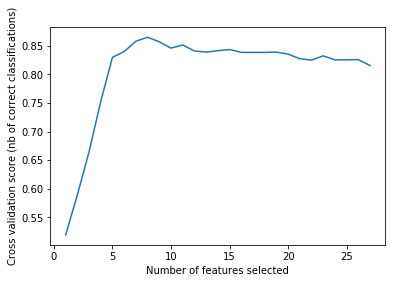

In [65]:
model = XGBClassifier(**{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'n_jobs': -1, 'reg_lambda': 3, 'seed': 20})
rfecv = sfs.RFECV(estimator=model, step=1, cv=StratifiedKFold(5, random_state=seed),
              scoring='accuracy', n_jobs=-1)
rfecv.fit(new_df, labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [66]:
new_df.columns[rfecv.support_]

Int64Index([64, 128, 451, 472, 153, 475, 493, 48], dtype='int64')

In [68]:
rfecv_columns = [64, 128, 451, 472, 153, 475, 493, 48]
all_scores = defaultdict(list)

model = XGBClassifier()
best_score, best_params, best_comb = 0, None, None

for i in tqdm(range(4, len(rfecv_columns))):
    for comb in itertools.combinations(rfecv_columns, i):
        params = {
            'max_depth': [2, 3, 5],
            'learning_rate': [0.1, 0.01],
            'n_estimators': [100, 300],
            'reg_lambda': [0.5, 1, 3, 9],
            'n_jobs': [-1],
            'seed': [seed],
        }
        search = GridSearchCV(model, params, cv=5, n_jobs=-1)
        t_df = df[list(comb)]
        search.fit(t_df, labels)
        if search.best_score_ > best_score:
            best_score = search.best_score_
            best_params = search.best_params_
            best_comb = comb
        all_scores[i].append((comb, search.best_score_))

print(best_score)
print(best_params)
print(best_comb)

0.864
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'n_jobs': -1, 'reg_lambda': 3, 'seed': 20}
(128, 451, 153, 475, 493, 48)


In [69]:
for k, v in all_scores.items():
    print(k, max(v, key=lambda x: x[1]))

4 ((64, 472, 493, 48), 0.8095)
5 ((128, 451, 153, 475, 48), 0.854)
6 ((128, 451, 153, 475, 493, 48), 0.864)
7 ((64, 451, 472, 153, 475, 493, 48), 0.8635)


### LightGBM

In [70]:
model = LGBMClassifier()
params = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [20, 100, 300, 1000],
    'reg_lambda': [0.5, 1, 3, 9],
    'num_leaves': [15, 31, 100],
    'n_jobs': [-1],
    'random_state': [seed],
}
search = GridSearchCV(model, params, cv=3, n_jobs=-1)
search.fit(new_df, labels)
search.best_params_, search.best_score_

({'learning_rate': 0.1,
  'n_estimators': 20,
  'n_jobs': -1,
  'num_leaves': 31,
  'random_state': 20,
  'reg_lambda': 0.5},
 0.8345)

Optimal number of features : 9


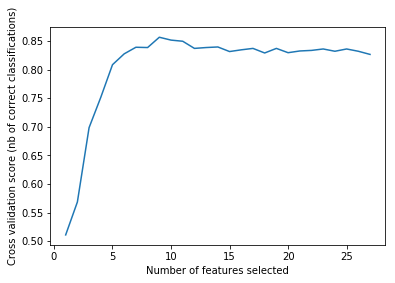

In [71]:
model = LGBMClassifier(**{'learning_rate': 0.1, 'n_estimators': 20, 'n_jobs': -1, 'num_leaves': 31, 'random_state': 20, 'reg_lambda': 0.5})
rfecv = sfs.RFECV(estimator=model, step=1, cv=StratifiedKFold(5, random_state=seed),
              scoring='accuracy', n_jobs=-1)
rfecv.fit(new_df, labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [73]:
new_df.columns[rfecv.support_]

Int64Index([64, 128, 451, 472, 153, 475, 493, 48, 241], dtype='int64')

In [75]:
rfecv_columns = [64, 128, 451, 472, 153, 475, 493, 48, 241]
all_scores = defaultdict(list)

model = LGBMClassifier()
best_score, best_params, best_comb = 0, None, None

for i in tqdm(range(4, len(rfecv_columns))):
    for comb in itertools.combinations(rfecv_columns, i):
        params = {
            'max_depth': [2, 3, 5],
            'learning_rate': [0.1, 0.01],
            'n_estimators': [100, 300],
            'reg_lambda': [0.5, 1, 3, 9],
            'n_jobs': [-1],
            'seed': [seed],
        }
        search = GridSearchCV(model, params, cv=5, n_jobs=-1)
        t_df = df[list(comb)]
        search.fit(t_df, labels)
        if search.best_score_ > best_score:
            best_score = search.best_score_
            best_params = search.best_params_
            best_comb = comb
        all_scores[i].append((comb, search.best_score_))

print(best_score)
print(best_params)
print(best_comb)

0.87
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'n_jobs': -1, 'reg_lambda': 1, 'seed': 20}
(64, 128, 451, 472, 153, 493, 48, 241)


In [76]:
for k, v in all_scores.items():
    print(k, max(v, key=lambda x: x[1]))

4 ((64, 472, 493, 48), 0.8005)
5 ((128, 451, 153, 475, 48), 0.8515)
6 ((128, 451, 153, 493, 48, 241), 0.8645)
7 ((64, 451, 472, 153, 493, 48, 241), 0.867)
8 ((64, 128, 451, 472, 153, 493, 48, 241), 0.87)


## Final modifications

In [97]:
from sklearn.ensemble import VotingClassifier

final_features = [64, 128, 451, 153, 475, 493, 48]
final_df = df[final_features]

m1 = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=20)

In [98]:
m = XGBClassifier()
params = {
            'max_depth': [2, 3, 5],
            'learning_rate': [0.1, 0.01],
            'n_estimators': [100, 300],
            'reg_lambda': [0.5, 1, 3, 9],
            'n_jobs': [-1],
            'seed': [seed],
        }
search = GridSearchCV(m, params, cv=5, n_jobs=-1)
search.fit(final_df, labels)
m2 = search.best_estimator_
search.best_score_, search.best_params_

(0.8605,
 {'learning_rate': 0.1,
  'max_depth': 5,
  'n_estimators': 300,
  'n_jobs': -1,
  'reg_lambda': 3,
  'seed': 20})

In [99]:
m = LGBMClassifier()
params = {
    'max_depth': [2, 3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 300],
    'reg_lambda': [0.5, 1, 3, 9],
    'n_jobs': [-1],
    'seed': [seed],
}
search = GridSearchCV(m, params, cv=5, n_jobs=-1)
search.fit(final_df, labels)
m3 = search.best_estimator_
search.best_score_, search.best_params_

(0.863,
 {'learning_rate': 0.1,
  'max_depth': 5,
  'n_estimators': 300,
  'n_jobs': -1,
  'reg_lambda': 1,
  'seed': 20})

In [128]:
m = CatBoostClassifier()
params = {
    'depth': [2, 3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'iterations': [100, 300, 1000],
    'reg_lambda': [0.5, 1, 3, 9],
    'random_state': [seed],
    'silent': [True]
}
search = GridSearchCV(m, params, cv=5, n_jobs=4)
search.fit(final_df, labels)
m4 = search.best_estimator_
search.best_score_, search.best_params_

(0.44,
 {'depth': 7,
  'iterations': 1000,
  'learning_rate': 0.01,
  'random_state': 20,
  'reg_lambda': 0.5,
  'silent': True})

In [102]:
# model = VotingClassifier(estimators=[('rf', m1), ('xgb', m2), ('lgbn', m3)], voting='hard', n_jobs=-1)
cross_validate(m1, final_df, labels, cv=5)

/home/bartek/Workspace/venvs/myenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.85865283, 0.90483904, 0.87438893, 0.84884143, 0.85462236]),
 'score_time': array([0.30586195, 0.20391273, 0.20369387, 0.2038784 , 0.20333433]),
 'test_score': array([0.875 , 0.9   , 0.885 , 0.8825, 0.8925]),
 'train_score': array([1., 1., 1., 1., 1.])}

## Add squares

In [120]:
square_df = final_df.copy()
for col in final_df.columns:
    new_col = str(col) + '^2'
    new_vals = square_df[col].apply(lambda x: x**2)
    square_df[new_col] = new_vals
    
    
# for col_a, col_b in itertools.combinations(final_df.columns, 2):
#     new_col = str(col_a) + '*' + str(col_b)
#     new_vals = square_df[[col_a, col_b]].apply(lambda row: row[col_a] * row[col_b], axis=1)
#     square_df[new_col] = new_vals
    
square_df.columns

Index([     64,     128,     451,     153,     475,     493,      48,  '64^2',
       '128^2', '451^2', '153^2', '475^2', '493^2',  '48^2'],
      dtype='object')

In [121]:
model = RandomForestClassifier()
params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 50, 100],
    'n_estimators': [20, 100, 300, 1000],
    'n_jobs': [-1],
    'random_state': [seed],
}
search = GridSearchCV(model, params, cv=5, n_jobs=-1)
search.fit(square_df, labels)
search.best_params_, search.best_score_

({'criterion': 'gini',
  'min_samples_split': 2,
  'n_estimators': 1000,
  'n_jobs': -1,
  'random_state': 20},
 0.8895)

Optimal number of features : 14


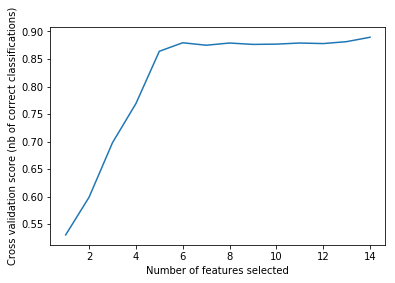

In [122]:
model = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=20)
rfecv = sfs.RFECV(estimator=model, step=1, cv=StratifiedKFold(5, random_state=seed),
              scoring='accuracy', n_jobs=-1)
rfecv.fit(square_df, labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [124]:
m = LGBMClassifier()
params = {
    'max_depth': [2, 3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 300],
    'reg_lambda': [0.5, 1, 3, 9],
    'n_jobs': [-1],
    'seed': [seed],
}
search = GridSearchCV(m, params, cv=5, n_jobs=-1)
search.fit(square_df, labels)
search.best_score_, search.best_params_

(0.863,
 {'learning_rate': 0.1,
  'max_depth': 5,
  'n_estimators': 300,
  'n_jobs': -1,
  'reg_lambda': 1,
  'seed': 20})

In [125]:
m = XGBClassifier()
params = {
            'max_depth': [2, 3, 5],
            'learning_rate': [0.1, 0.01],
            'n_estimators': [100, 300],
            'reg_lambda': [0.5, 1, 3, 9],
            'n_jobs': [-1],
            'seed': [seed],
        }
search = GridSearchCV(m, params, cv=5, n_jobs=-1)
search.fit(square_df, labels)
m2 = search.best_estimator_
search.best_score_, search.best_params_

(0.8605,
 {'learning_rate': 0.1,
  'max_depth': 5,
  'n_estimators': 300,
  'n_jobs': -1,
  'reg_lambda': 3,
  'seed': 20})

In [129]:
m = CatBoostClassifier()
params = {
    'depth': [2, 3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'iterations': [100, 300, 1000],
    'reg_lambda': [0.5, 1, 3, 9],
    'random_state': [seed],
    'silent': [True]
}
search = GridSearchCV(m, params, cv=5, n_jobs=4)
search.fit(square_df, labels)
m4 = search.best_estimator_
search.best_score_, search.best_params_

(0.4385,
 {'depth': 7,
  'iterations': 300,
  'learning_rate': 0.1,
  'random_state': 20,
  'reg_lambda': 1,
  'silent': True})

## Try to replace columns with highly correlated
### Using random forest due to best performance

In [22]:
from copy import deepcopy

rfecv_columns = [64, 128, 451, 472, 153, 475, 493, 48]
cors = [[28, 318, 451], [48, 378], [64, 336], [105, 128], [153, 281, 433], [241, 475], [442, 472], [453, 493]]
cor_mapping = {}
for used_col in rfecv_columns:
    for cor in cors:
        if used_col in cor:
            for f in cor:
                cor_mapping[f] = used_col        

all_scores = defaultdict(list)

model = RandomForestClassifier()
best_score, best_params, best_comb = 0, None, None

for comb in tqdm(list(itertools.product(*cors))):
    comb_columns = deepcopy(rfecv_columns)
    for f in comb:
        for i in range(len(comb_columns)):
            if cor_mapping[f] == comb_columns[i]:
                comb_columns[i] = f
                break
            
    params = {
        'criterion': ['gini', 'entropy'],
        'min_samples_split': [2, 10, 50, 100],
        'n_estimators': [20, 100, 300, 1000],
        'n_jobs': [-1],
        'random_state': [seed],
    }
    search = GridSearchCV(model, params, cv=5, n_jobs=-1)
    t_df = df[comb_columns]
    search.fit(t_df, labels)
    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_params = search.best_params_
        best_comb = comb_columns
    all_scores[i].append((comb, search.best_score_))

print(best_score)
print(best_params)
print(best_comb)



0.898
{'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 20}
(451, 378, 64, 128, 281, 241, 442, 493)


In [19]:
comb_columns = [64, 128, 451, 472, 153, 475, 493, 48]
cors = [[28, 318, 451], [48, 378], [64, 336], [105, 128], [153, 281, 433], [241, 475], [442, 472], [453, 493]]
cor_mapping = {}
for used_col in comb_columns:
    for cor in cors:
        if used_col in cor:
            for f in cor:
                cor_mapping[f] = used_col      
                
comb = (451, 378, 64, 128, 281, 241, 442, 493)
for f in comb:
    for i in range(len(comb_columns)):
        if cor_mapping[f] == comb_columns[i]:
            comb_columns[i] = f
            break
            
print(comb_columns)

[64, 128, 451, 442, 281, 241, 493, 378]


In [20]:
best_cols = [64, 128, 451, 442, 281, 241, 493, 378]
model = RandomForestClassifier(**{'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 20})
sc = cross_validate(model, df[best_cols], labels, cv=5, scoring=make_scorer(balanced_accuracy_score), return_train_score=False)
np.mean(sc['test_score'])

0.898

### Again try squaring

In [23]:
best_cols = [64, 128, 451, 442, 281, 241, 493, 378]
square_df = df[best_cols].copy()
for col in best_cols:
    new_col = str(col) + '^2'
    new_vals = square_df[col].apply(lambda x: x**2)
    square_df[new_col] = new_vals
    
square_df.columns

Index([     64,     128,     451,     442,     281,     241,     493,     378,
        '64^2', '128^2', '451^2', '442^2', '281^2', '241^2', '493^2', '378^2'],
      dtype='object')

In [25]:
model = RandomForestClassifier()
params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 30, 50, 75, 100],
    'n_estimators': [20, 100, 300, 500, 1000],
    'bootstrap': [True, False],
    'max_features': ['auto', None],
    'n_jobs': [-1],
    'random_state': [seed],
}
search = GridSearchCV(model, params, cv=5, scoring=make_scorer(balanced_accuracy_score), n_jobs=-1)
search.fit(square_df, labels)
search.best_params_, search.best_score_

({'bootstrap': True,
  'criterion': 'gini',
  'max_features': 'auto',
  'min_samples_split': 2,
  'n_estimators': 100,
  'n_jobs': -1,
  'random_state': 20},
 0.893)

In [26]:
model = RandomForestClassifier()
params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 30, 50, 75, 100],
    'n_estimators': [20, 100, 300, 500, 1000],
    'bootstrap': [True, False],
    'max_features': ['auto', None],
    'n_jobs': [-1],
    'random_state': [seed],
}
search = GridSearchCV(model, params, cv=5, scoring=make_scorer(balanced_accuracy_score), n_jobs=-1)
search.fit(df[best_cols], labels)
search.best_params_, search.best_score_

({'bootstrap': True,
  'criterion': 'gini',
  'max_features': 'auto',
  'min_samples_split': 2,
  'n_estimators': 300,
  'n_jobs': -1,
  'random_state': 20},
 0.898)